<a href="https://colab.research.google.com/github/peeyushsinghal/DA-CV/blob/main/domain_adaptation_cv_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Setup
%matplotlib inline
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
gdrive_file = '/content/gdrive/MyDrive/MNISTM/mnist_m.tar.gz'
data_dir = '/content'

In [ ]:
# !wget https://github.com/peeyushsinghal/DA-CV/blob/main/data/test_mnist_m.tar.gz
# !wget https://github.com/peeyushsinghal/DA-CV/blob/main/data/train_mnist_m.tar.gz

In [ ]:
import tarfile
my_tar = tarfile.open(gdrive_file, "r:gz")
my_tar.extractall(data_dir) # specify which folder to extract to
my_tar.close()

Source is MNIST, Target is MNIST-M

In [ ]:
image_size = 28
batch_size = 4

In [ ]:
tf_source = transforms.Compose([transforms.Resize(image_size),
                          transforms.ToTensor(),
                          transforms.Normalize(mean=(0.1307,), std=(0.3081,))
                          ])
tf_target = transforms.Compose([transforms.Resize(image_size),
                          transforms.ToTensor(),
                          transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                          ])

Downloading MNIST and creating a data loader

In [ ]:
ds_source_train = tv.datasets.MNIST(root="./", train=True, transform=tf_source, download=True)
ds_source_val = tv.datasets.MNIST(root="./", train=False, transform=tf_source, download=True)
dl_source_train = torch.utils.data.DataLoader(ds_source_train, batch_size)
dl_source_val = torch.utils.data.DataLoader(ds_source_val, batch_size)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Working on MNIST-M Dataset

In [ ]:
import torch.utils.data as data
from PIL import Image
import os


class MNISTMDataset(data.Dataset):
    def __init__(self, data_root, data_list, transform=None):
        self.root = data_root
        self.transform = transform

        f = open(data_list, 'r')
        data_list = f.readlines()
        f.close()

        self.n_data = len(data_list)

        self.img_paths = []
        self.img_labels = []

        for data in data_list:
            self.img_paths.append(data[:-3])
            self.img_labels.append(data[-2])

    def __getitem__(self, item):
        img_paths, labels = self.img_paths[item], self.img_labels[item]
        imgs = Image.open(os.path.join(self.root, img_paths)).convert('RGB')

        if self.transform is not None:
            imgs = self.transform(imgs)
            labels = int(labels)

        return imgs, labels

    def __len__(self):
        return self.n_data

In [ ]:
ds_target_train = MNISTMDataset(os.path.join(data_dir, 'mnist_m', 'mnist_m_train'),
                          os.path.join(data_dir, 'mnist_m', 'mnist_m_train_labels.txt'),
                         transform=tf_target)

ds_target_val = MNISTMDataset(os.path.join(data_dir, 'mnist_m', 'mnist_m_test'),
                          os.path.join(data_dir, 'mnist_m', 'mnist_m_test_labels.txt'),
                         transform=tf_target)



dl_target_train = torch.utils.data.DataLoader(ds_target_train, batch_size)
dl_target_val = torch.utils.data.DataLoader(ds_target_val, batch_size)


In [ ]:
import math
import itertools

import numpy as np
import matplotlib.pyplot as plt


def tensors_as_images(tensors, nrows=1, figsize=(8, 8), titles=[],
                      wspace=0.1, hspace=0.2, cmap=None):
    """
    Plots a sequence of pytorch tensors as images.

    :param tensors: A sequence of pytorch tensors, should have shape CxWxH
    """
    assert nrows > 0

    num_tensors = len(tensors)

    ncols = math.ceil(num_tensors / nrows)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize,
                             gridspec_kw=dict(wspace=wspace, hspace=hspace),
                             subplot_kw=dict(yticks=[], xticks=[]))
    axes_flat = axes.reshape(-1)

    # Plot each tensor
    for i in range(num_tensors):
        ax = axes_flat[i]

        image_tensor = tensors[i]
        assert image_tensor.dim() == 3  # Make sure shape is CxWxH

        image = image_tensor.numpy()
        image = image.transpose(1, 2, 0)
        image = image.squeeze()  # remove singleton dimensions if any exist

        # Scale to range 0..1
        min, max = np.min(image), np.max(image)
        image = (image-min) / (max-min)

        ax.imshow(image, cmap=cmap)

        if len(titles) > i and titles[i] is not None:
            ax.set_title(titles[i])

    # If there are more axes than tensors, remove their frames
    for j in range(num_tensors, len(axes_flat)):
        axes_flat[j].axis('off')

    return fig, axes


def dataset_first_n(dataset, n, show_classes=False, class_labels=None,
                    random_start=True, **kw):
    """
    Plots first n images of a dataset containing tensor images.
    """

    if random_start:
        start = np.random.randint(0, len(dataset) - n)
        stop = start + n
    else:
        start = 0
        stop = n

    # [(img0, cls0), ..., # (imgN, clsN)]
    first_n = list(itertools.islice(dataset, start, stop))

    # Split (image, class) tuples
    first_n_images, first_n_classes = zip(*first_n)

    if show_classes:
        titles = first_n_classes
        if class_labels:
            titles = [class_labels[cls] for cls in first_n_classes]
    else:
        titles = []

    return tensors_as_images(first_n_images, titles=titles, **kw)

(<Figure size 576x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

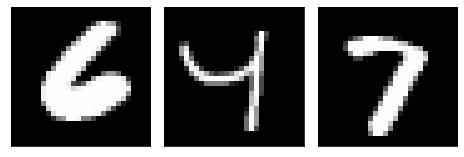

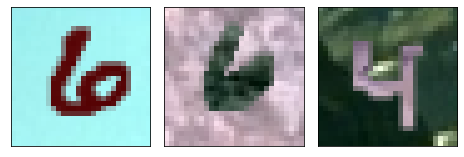

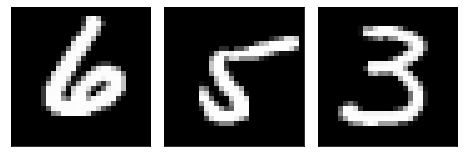

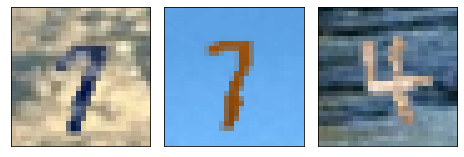

In [ ]:
## Showing first n images of the dataset
dataset_first_n(ds_source_train, 3, cmap='gray')
dataset_first_n(ds_target_train, 3)
dataset_first_n(ds_source_val, 3, cmap='gray')
dataset_first_n(ds_target_val, 3)

## Model

Our model will consist of three parts, as in the figure:

* A "deep" CNN for image feature extraction (2x Conv, ReLU, MaxPool)
* A digit-classification head (3x FC, ReLU)
* A domain classification head (2x FC, ReLU), with gradient reversal layer (GRL)

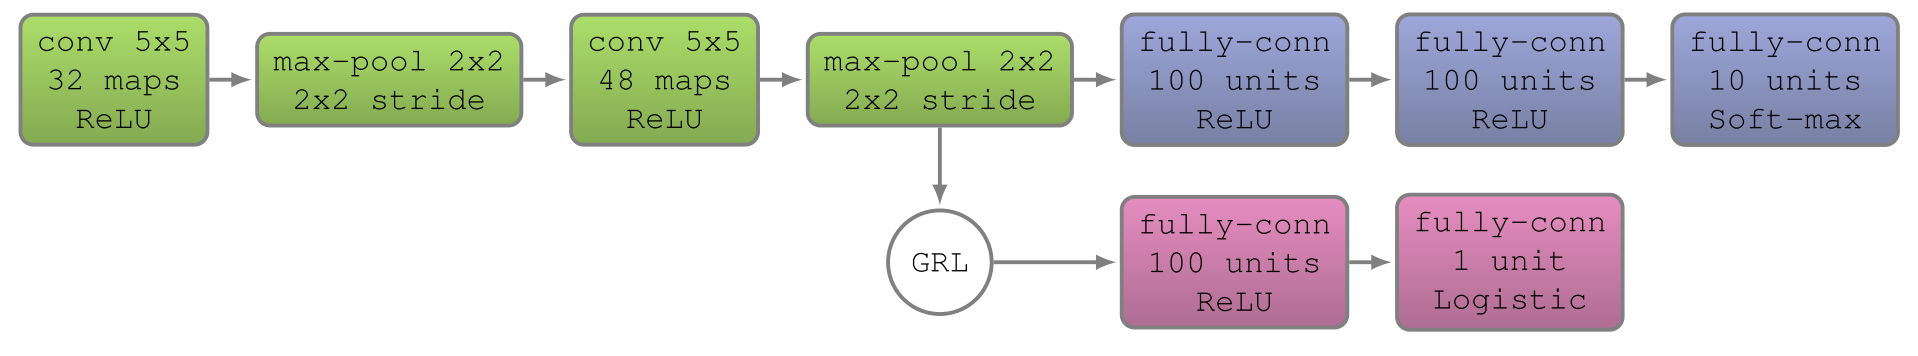

Recall: GRL is no-op in forward pass, but applies  −𝜆  factor to gradient in the backward pass.

### GRL Layer Implementation

In [ ]:
from torch.autograd import Function

# Autograd Function objects are what record operation history on tensors,
# and define formulas for the forward and backprop.

class GradientReversalFn(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        # Store context for backprop
        ctx.alpha = alpha
        
        # Forward pass is a no-op
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        # Backward pass is just to -alpha the gradient
        output = grad_output.neg() * ctx.alpha

        # Must return same number as inputs to forward()
        return output, None

### Domain Adaptation CNN Model

In [ ]:

class DACNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5), # input - 3x28x28, output - 64x24x24
            nn.BatchNorm2d(64), nn.MaxPool2d(2), # input - 64x24x24, output - 64x12x12
            nn.ReLU(True),
            nn.Conv2d(64, 50, kernel_size=5), # input - 64x12x12, output - 50x8x8
            nn.BatchNorm2d(50), nn.Dropout(0.05), nn.MaxPool2d(2), # input - 50x8x8, output - 50x4x4
            nn.ReLU(True),
        )
        self.class_classifier = nn.Sequential(
            nn.Linear(50 * 4 * 4, 100), nn.BatchNorm1d(100), nn.Dropout(0.05), # FC1
            nn.ReLU(True),
            nn.Linear(100, 100), nn.BatchNorm1d(100),# FC2
            nn.ReLU(True),
            nn.Linear(100, 10),# FC3
            nn.LogSoftmax(dim=1),
        )
        self.domain_classifier = nn.Sequential(
            nn.Linear(50 * 4 * 4, 100), nn.BatchNorm1d(100), # FC1
            nn.ReLU(True),
            nn.Linear(100, 2),# FC2
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x, grl_lambda=1.0):
        # Handle single-channel input by expanding (repeating) the singleton dimention
        x = x.expand(x.data.shape[0], 3, image_size, image_size)
        
        features = self.feature_extractor(x)
        features = features.view(-1, 50 * 4 * 4)
        reverse_features = GradientReversalFn.apply(features, grl_lambda)
        
        class_pred = self.class_classifier(features)
        domain_pred = self.domain_classifier(reverse_features)
        return class_pred, domain_pred

Wait, but why let $\lambda$ (`grl_lambda` in the code) change during training (e.g. every epoch)?

- In the beginning of training, the domain loss is extremely noisy since the CNN features are not good yet.
- Therefore, lambda is gradualy changed from 0 to 1 in the course of training.
    $$
    \lambda_p = \frac{2}{1+\exp(-10\cdot p)} -1,
    $$
    where $p\in[0,1]$ is the training progress.

In [ ]:
model = DACNN()
model

DACNN(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 50, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout2d(p=0.5, inplace=False)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU(inplace=True)
  )
  (class_classifier): Sequential(
    (0): Linear(in_features=800, out_features=100, bias=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout2d(p=0.5, inplace=False)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running

In [ ]:
!pip install torchinfo 
temp_model = DACNN().to(device)
batch_size = 2
summary(temp_model, input_size=(batch_size, 3, 28, 28))

#### Checking if the model, dataloader etc. are working by sending data to untrained model

In [ ]:
x0_s_train, y0_s_train = next(iter(dl_source_train))
x0_t_train, y0_t_train = next(iter(dl_target_train))


print('source domain: ', x0_s_train.shape, y0_s_train.shape)
print('target domain: ', x0_t_train.shape, y0_t_train.shape)

print(model(x0_s_train))
print(model(x0_t_train))

source domain:  torch.Size([4, 1, 28, 28]) torch.Size([4])
target domain:  torch.Size([4, 3, 28, 28]) torch.Size([4])
(tensor([[-2.4823, -2.9627, -2.8780, -2.5407, -1.9023, -1.3175, -2.6580, -2.4428,
         -2.5820, -2.5248],
        [-1.8210, -2.5940, -2.8001, -2.1638, -2.7580, -2.2207, -2.2873, -2.1393,
         -2.4549, -2.2015],
        [-2.1401, -2.1971, -1.8836, -2.4677, -2.2931, -1.9864, -3.1085, -2.0172,
         -2.3999, -3.5809],
        [-1.9427, -2.1691, -2.7427, -2.1226, -1.9136, -2.6047, -2.5879, -2.3799,
         -2.4649, -2.4763]], grad_fn=<LogSoftmaxBackward0>), tensor([[-0.3863, -1.1381],
        [-0.3704, -1.1727],
        [-0.5918, -0.8059],
        [-0.6406, -0.7486]], grad_fn=<LogSoftmaxBackward0>))
(tensor([[-1.8447, -2.4778, -2.7259, -2.4943, -1.7838, -1.7162, -3.2365, -2.2038,
         -2.9671, -2.7959],
        [-1.9640, -2.0652, -3.2381, -2.0769, -2.4492, -2.1333, -2.1626, -2.0267,
         -2.7541, -2.9358],
        [-2.4341, -2.3138, -1.8427, -1.8841, -2.

/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


### Source Training *Function*

In [ ]:
### Source Training Function
from tqdm import tqdm # for beautiful model training updates

def train_model(model, device, train_loader,optimizer,epoch):
    model.train() # setting the model in training mode
    pbar = tqdm(train_loader) # putting the iterator in pbara
    correct = 0 # for accuracy numerator
    processed =0 # for accuracy denominator

    for batch_idx, batch in enumerate(pbar):

        X_s, y_s = batch[0].to(device), batch[1].long().to(device) 
        #sending data to CPU or GPU as per device
        optimizer.zero_grad() # setting gradients to zero to avoid accumulation

        class_pred, _ = model(X_s, grl_lambda = 0)
        loss = F.nll_loss(class_pred, y_s) # capturing loss
        # forward pass, result captured in y_preds (plural as there are many body in a batch)
        # we are not interested in domain prediction
        # the predictions are in one hot vector
        
        loss.backward() # backpropagation
        optimizer.step() # updating the params

        preds = class_pred.argmax(dim=1, keepdim=True)  # get the index olf the max log-probability
        correct += preds.eq(y_s.view_as(preds)).sum().item()

        processed += len(X_s)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')


### Typical Test Function

In [ ]:
## This is same as DANN test function

### DANN Training *Function*

In [ ]:
# DANN Training Function

def dann_train_model(model, device, train_source_loader, train_target_loader,optimizer, epoch, num_epochs):
    model.train() # setting the model in training mode
    # understanding batch size by understanding length of two dataloaders
    len_dataloader = min(len(train_source_loader), len(train_target_loader)) # training for minimum of two dataloaders

    i = 0 # as the training progresses the alpha changes
    while i < len_dataloader -1:
        # implementation of alpha as per paper
        p = float(i + epoch * len_dataloader) / (num_epochs * len_dataloader)
        grl_lambda = 2. / (1. + np.exp(-10 * p)) - 1

        # Train on source domain
        X_s, y_s = next(iter(train_source_loader))
        X_s, y_s = X_s.to(device), y_s.to(device)
        y_s_domain = torch.zeros(batch_size, dtype=torch.long).to(device) # generate source domain labels

        class_pred, domain_pred = model(X_s, grl_lambda)
        loss_s_label = F.nll_loss(class_pred, y_s)
        loss_s_domain = F.nll_loss(domain_pred, y_s_domain)

        # Train on target domain
        X_t, _ = next(iter(train_target_loader)) # ignore target domain class labels!
        X_t = X_t.to(device)
        y_t_domain = torch.ones(batch_size, dtype=torch.long).to(device) # generate target domain labels

        _, domain_pred = model(X_t, grl_lambda) # ignore the model output in terms of class labels
        loss_t_domain = F.nll_loss(domain_pred, y_t_domain)
        
        loss = loss_t_domain + loss_s_domain + loss_s_label
        loss.backward()
        optimizer.step()

        if ((i + 1) % 10 == 0):
          print(f'[{i+1}/{len_dataloader}] '
                f'class_loss: {loss_s_label.item():.4f} ' f's_domain_loss: {loss_s_domain.item():.4f} '
                f't_domain_loss: {loss_t_domain.item():.4f} ' f'grl_lambda: {grl_lambda:.3f} '
              )
        
        i = i+1

### DANN Test *Function*

In [ ]:
# DANN Test Function

def dann_test_model(model, device, test_loader):
    model.eval() # setting the model in evaluation mode
    grl_lambda = 0
    test_loss = 0
    correct = 0  # for accuracy numerator

    with torch.no_grad():
        for (X_t,y_t) in test_loader:
            
            X_t, y_t = X_t.to(device), y_t.long().to(device) #sending data to CPU or GPU as per device
            class_outputs, _  = model(X_t, grl_lambda = grl_lambda) # forward pass, plural results
            
            test_loss = F.nll_loss(class_outputs, y_t, reduction='sum').item()  # sum up batch loss
            preds = class_outputs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += preds.eq(y_t.view_as(preds)).sum().item()
        
        test_loss /= len(test_loader.dataset) # average test loss

            
        print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%) \n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

### Test and Training Declarations

In [ ]:
lr = 1e-3
n_epochs = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Setup optimizer as usual

typical_model = DACNN()
typical_model = typical_model.to(device)
optimizer = optim.Adam(typical_model.parameters(), lr)

dann_model = DACNN()
dann_model = dann_model.to(device)
optimizer_dann = optim.Adam(dann_model.parameters(), lr) # note the change in optimizer



batch_size = 2048

dl_source_train = torch.utils.data.DataLoader(ds_source_train, batch_size)
dl_source_val = torch.utils.data.DataLoader(ds_source_val, batch_size)
dl_target_train = torch.utils.data.DataLoader(ds_target_train, batch_size)
dl_target_val = torch.utils.data.DataLoader(ds_target_val, batch_size)


cuda


### Typical Model Training and Testing Loop

In [ ]:
## Typical model
for epoch in range(n_epochs):
    print("EPOCH:", epoch+1)
    train_model(typical_model, device, dl_source_train, optimizer, epoch)
    print('\nTesting on Source Val......')
    dann_test_model(typical_model, device, dl_source_val)
    print('\nTesting on Target Val......')
    dann_test_model(typical_model, device, dl_target_val)
print("Typical model training and validation completed")

EPOCH: 1


Loss=0.6377901434898376 Batch_id=29 Accuracy=71.86: 100%|██████████| 30/30 [00:27<00:00,  1.10it/s]



Testing on Source Val......
Test set: Average loss: 0.0807, Accuracy: 9543/10000 (95.43%) 


Testing on Target Val......
Test set: Average loss: 0.2150, Accuracy: 1576/9001 (17.51%) 

EPOCH: 2


Loss=0.26478293538093567 Batch_id=29 Accuracy=93.52: 100%|██████████| 30/30 [00:19<00:00,  1.53it/s]



Testing on Source Val......
Test set: Average loss: 0.0248, Accuracy: 9766/10000 (97.66%) 


Testing on Target Val......
Test set: Average loss: 0.2495, Accuracy: 1443/9001 (16.03%) 

Typical model training and validation completed


### DANN Training and Testing Loop

In [ ]:
### DANN
for epoch in range(n_epochs):
    print("EPOCH:", epoch+1)
    dann_train_model(dann_model, device, dl_source_train, dl_target_train, optimizer_dann, epoch, num_epochs = n_epochs)
    print('Testing on Source Val......')
    dann_test_model(dann_model, device, dl_source_val)
    print('Testing on Target Val......')
    dann_test_model(dann_model, device, dl_target_val)
print("DANN model training and validtion completed")

EPOCH: 1
[10/29] class_loss: 1.5409 s_domain_loss: 0.6986 t_domain_loss: 0.6902 grl_lambda: 0.650 
[20/29] class_loss: 1.0965 s_domain_loss: 0.6151 t_domain_loss: 0.8035 grl_lambda: 0.927 
Testing on Source Val......
Test set: Average loss: 0.0892, Accuracy: 8443/10000 (84.43%) 

Testing on Target Val......
Test set: Average loss: 0.1903, Accuracy: 2415/9001 (26.83%) 

EPOCH: 2
[10/29] class_loss: 0.6330 s_domain_loss: 0.7498 t_domain_loss: 0.6640 grl_lambda: 0.997 
[20/29] class_loss: 0.4806 s_domain_loss: 0.9948 t_domain_loss: 0.4852 grl_lambda: 0.999 
Testing on Source Val......
Test set: Average loss: 0.0604, Accuracy: 8772/10000 (87.72%) 

Testing on Target Val......
Test set: Average loss: 0.1819, Accuracy: 2556/9001 (28.40%) 

DANN model training and validtion completed


### Confusion Metrics, Accuracy, Precision, Recall, F1

In [ ]:


# device = torch.device("cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device =",device)


classes = ('0','1','2','3','4','5','6','7','8','9')

dict_testloader = {"Source Val": dl_source_val,"Target Val":dl_target_val}
dict_model = {"Typical": typical_model,"DANN": dann_model}


device = cuda


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


------------Model = Typical, Domain Validation = Source Val---------
confusion matrix 
      0     1    2    3    4    5    6    7    8    9
0  972     0    1    0    0    0    4    1    2    0
1    0  1129    1    3    0    2    0    0    0    0
2    7     2  993    3    5    1    4   15    2    0
3    1     0    4  983    0   11    0    8    2    1
4    2     1    0    0  964    0    7    0    1    7
5    1     1    0    5    0  881    2    1    1    0
6    6     3    0    0    2    7  940    0    0    0
7    1     7   17    1    0    1    0  994    1    6
8    6     1    2    3    3    1    2    6  941    9
9    4     4    0    5    7    8    1    9    2  969
 Accuracy = 0.9766 
Precision = [0.972      0.98344948 0.97544204 0.98005982 0.98267074 0.96600877
 0.97916667 0.96131528 0.98844538 0.97681452] 
 Recall = [0.99183673 0.99471366 0.9622093  0.97326733 0.98167006 0.98766816
 0.98121086 0.96692607 0.9661191  0.96035679] 
f1 = [0.98181818 0.9890495  0.96878049 0.97665176 0.9821701

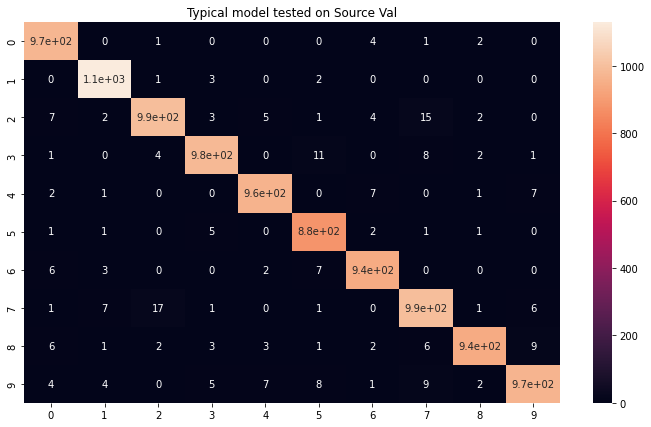

/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


------------Model = Typical, Domain Validation = Target Val---------
confusion matrix 
     0     1   2   3  4   5   6    7  8  9
0  52   807   4   0  0   9   1    5  0  0
1   0  1016   0   0  0   0   0    0  0  0
2   0   827  82   1  0   9   0   14  0  0
3   1   843   3  45  0   7   0    9  0  0
4   0   883   0   0  6   1   0    0  0  0
5   0   708   0   0  0  96   1    2  0  0
6   0   807   0   0  0   8  41    0  0  0
7   0   805   4   0  0   0   0  105  0  0
8   0   860   7   0  0   8   0    5  0  0
9   0   899   0   0  0   9   0   11  0  0
 Accuracy = 0.16031552049772246 
Precision = [0.98113208 0.12016558 0.82       0.97826087 1.         0.65306122
 0.95348837 0.69536424 0.         0.        ] 
 Recall = [0.05922551 1.         0.08788853 0.04955947 0.00674157 0.11895911
 0.0478972  0.11487965 0.         0.        ] 
f1 = [0.11170784 0.21454968 0.15876089 0.09433962 0.01339286 0.20125786
 0.09121246 0.1971831  0.         0.        ]


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


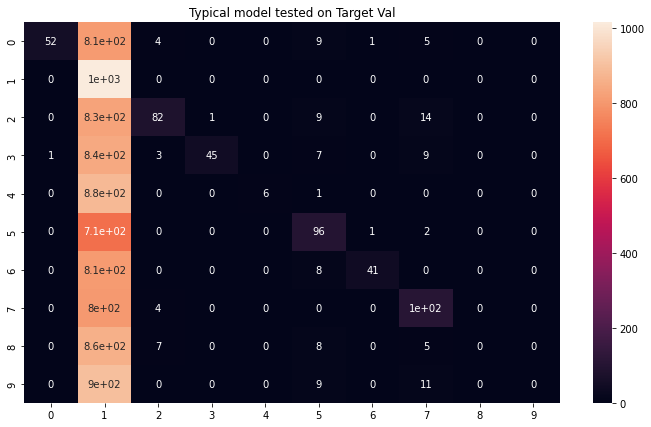

/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


------------Model = DANN, Domain Validation = Source Val---------
confusion matrix 
      0    1    2    3    4    5    6    7    8    9
0  932    0    5    5    0    1    7    2   27    1
1    0  816   18    4    0    2    3    2  289    1
2    4    0  924   29    2    1    5    7   59    1
3    0    0   16  862    0   57    1    5   64    5
4    1    0   14    0  885    0   43    0    8   31
5    4    0    1   18    0  758   10    3   79   19
6   14    1    5    0    1   20  903    0   14    0
7    1    1   52    7    5    0    3  832   15  112
8    0    0    3    8    2    3   12    2  929   15
9   10    0   10    7   11    3    1    3   33  931
 Accuracy = 0.8772 
Precision = [0.96480331 0.99755501 0.88167939 0.91702128 0.97682119 0.89704142
 0.91396761 0.97196262 0.61239288 0.83422939] 
 Recall = [0.95102041 0.71894273 0.89534884 0.85346535 0.901222   0.84977578
 0.94258873 0.80933852 0.95379877 0.92269574] 
f1 = [0.95786228 0.83563748 0.88846154 0.88410256 0.9375     0.87276914
 

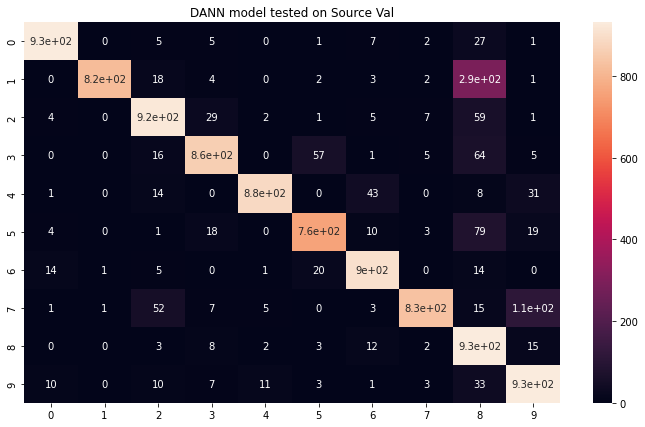

/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


------------Model = DANN, Domain Validation = Target Val---------
confusion matrix 
      0    1    2    3    4    5    6    7   8   9
0  296  475    7    5   16   25   23   26   3   2
1   47  764    1    1   46    2  144   10   1   0
2    9  513  225   10   93   28   19   35   1   0
3   12  522   33  118   44  106    9   30  31   3
4   44  540    4    4  230   34   13   21   0   0
5   31  405   21   14   24  235   22   32   9  14
6   39  473    2    6   12   33  271   19   0   1
7   19  473   78    9   32    9    0  290   1   3
8   42  577   22   12   24   29   55   32  80   7
9   73  526   12    7  174   22    3   54   1  47
 Accuracy = 0.28396844795022774 
Precision = [0.48366013 0.14502658 0.55555556 0.6344086  0.33093525 0.44933078
 0.48479428 0.52823315 0.62992126 0.61038961] 
 Recall = [0.33712984 0.7519685  0.24115756 0.12995595 0.25842697 0.29120198
 0.31658879 0.31728665 0.09090909 0.05114255] 
f1 = [0.39731544 0.24315722 0.33632287 0.21572212 0.29022082 0.35338346
 0.3830388

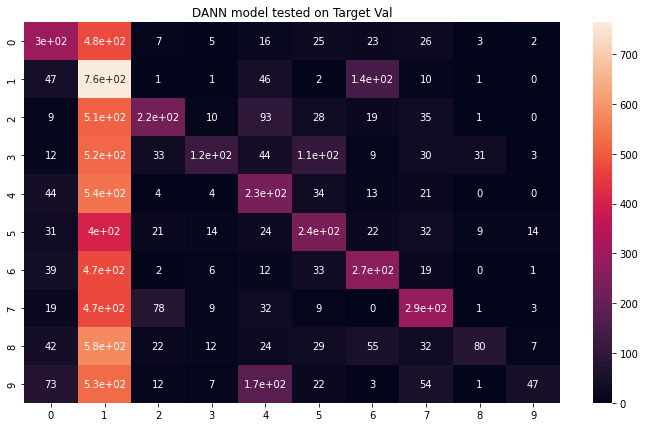

In [ ]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score,f1_score,accuracy_score

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


for model_name, model in dict_model.items():
  model.eval()  # setting the model into evaluation mode
  grl_lambda = 0
  for domain_name, test_loader  in dict_testloader.items():
    y_pred = []
    y_true = []

    for (X_t,y_t) in test_loader:
      X_t, y_t = X_t.to(device), y_t.long().to(device) #sending data to CPU or GPU as per device

      # Ground Truth Values
      truths = y_t.tolist()
      # truths = y_t.cpu().numpy() # CPU
      y_true.extend(truths) # Save Truth

      # Prediction Values
      class_outputs, _  = model(X_t, grl_lambda = grl_lambda) # forward pass, plural results
      preds = (torch.max(torch.exp(class_outputs), 1)[1]).tolist()

      # print(preds)
      # preds = class_outputs.argmax(dim=1, keepdim=True).data.cpu().numpy()  # CPU
      y_pred.extend(preds) # Save Predicted
      
    # Build confusion matrix
    print(f'------------Model = {model_name}, Domain Validation = {domain_name}---------')
    cf_matrix = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score (y_true, y_pred, average=None)
    f1 = f1_score (y_true, y_pred, average=None)

    df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                         columns = [i for i in classes])
    print("confusion matrix \n",df_cm)
    print (f' Accuracy = {accuracy} \nPrecision = {precision} \n Recall = {recall} \nf1 = {f1}')
    plt.figure(figsize = (12,7))
    ax = plt.axes()
    sn.heatmap(df_cm, ax= ax, annot=True)

    ax.set_title(model_name+" model tested on "+domain_name)
    plt.show()
    # sn.heatmap(df_cm, annot=True)
      
